In [ ]:
# Muhammad Asad Manzoor (21032326)

In [17]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import wbgapi as wb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.preprocessing import MinMaxScaler

## Clustering

In [18]:
country_codes = ['BLZ','IRQ']
country_nm=['Belize','Indonesia']
ind1=["EN.POP.DNST"]
ind1m=["Population density"]
ind2=["NY.GDP.MKTP.PP.CD"]
ind2m=["GDP per capita"]

In [19]:
my_dataframe1  = wb.data.DataFrame(ind1, country_codes, mrv=50).T
my_dataframe2  = wb.data.DataFrame(ind2, country_codes, mrv=50).T

In [20]:
my_dataframe1.head()

economy       BLZ        IRQ
YR1971   5.471065  23.448917
YR1972   5.574397  24.234998
YR1973   5.668303  25.038041
YR1974   5.756466  25.863827
YR1975   5.842350  26.715547

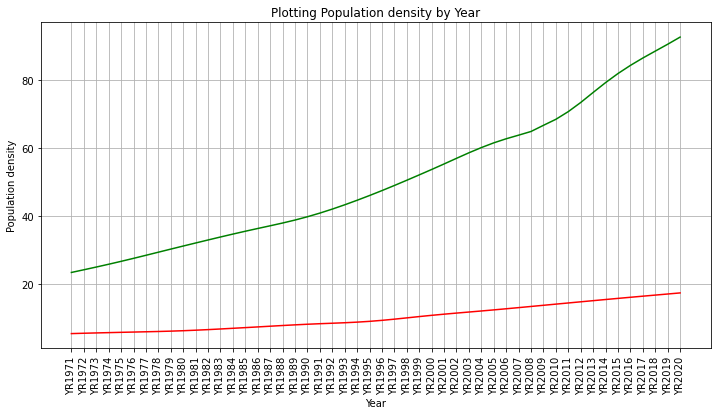

In [21]:
plt.figure(figsize=(12,6))
plt.title('Plotting Population density by Year')
plt.plot(my_dataframe1['BLZ'],"r")
plt.plot(my_dataframe1['IRQ'],"g")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Population density")
plt.grid()
plt.show()

In [22]:
my_dataframe2=my_dataframe2.fillna(my_dataframe2.mean())
my_dataframe2.head()

economy           BLZ           IRQ
YR1990   6.251010e+08  2.796086e+11
YR1991   7.203256e+08  4.788347e+10
YR1992   8.255798e+08  6.493663e+10
YR1993   8.981886e+08  8.661127e+10
YR1994   9.188220e+08  9.187054e+10

In [23]:
mnx=MinMaxScaler()
mnx.fit(my_dataframe1.values)
norml=mnx.transform(my_dataframe1.values)
norml[:10]

array([[0.        , 0.        ],
       [0.00863921, 0.01135916],
       [0.01649036, 0.02296344],
       [0.02386136, 0.03489636],
       [0.03104176, 0.04720404],
       [0.03792894, 0.05989429],
       [0.04469882, 0.0728914 ],
       [0.05197452, 0.08606148],
       [0.06050376, 0.09922528],
       [0.07091333, 0.11225071]])

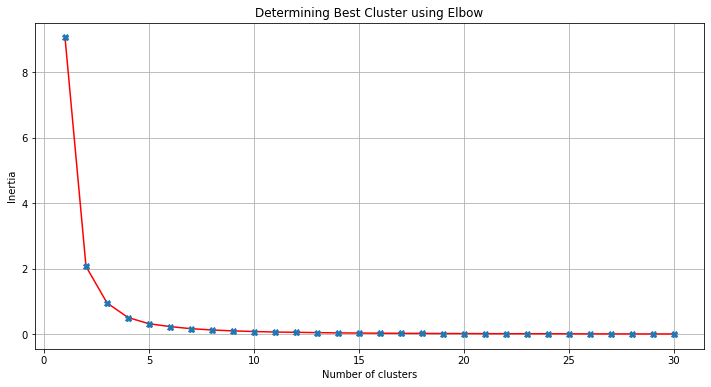

In [24]:
wcss = []
for i in range(1, 31):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300,  random_state=0)
    kmeans.fit(norml)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))
plt.title('Determining Best Cluster using Elbow')
plt.plot(range(1, 31), wcss,"r")
plt.plot(range(1, 31), wcss,"X")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [25]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit(norml)
#pred_y_n=['Cluster-{}'.format(i) for i in pred_y]
pred_y

KMeans(n_clusters=4, random_state=0)

In [26]:
kmeans.cluster_centers_

array([[0.8919246 , 0.87108701],
       [0.29342328, 0.30508003],
       [0.61277784, 0.56773448],
       [0.06765942, 0.09284333]])

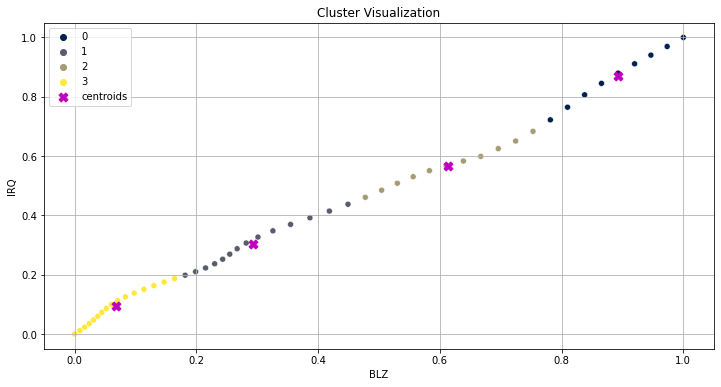

In [27]:
df=pd.DataFrame(norml,columns=["BLZ","IRQ"])
plt.figure(figsize=(12,6))
plt.title('Cluster Visualization')
sns.scatterplot(data=df, x="BLZ", y="IRQ", hue=kmeans.labels_,palette="cividis")
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="X", c="m", s=80, label="centroids")
plt.grid()
plt.legend()
plt.show()

## Curve Fitting

In [28]:
from scipy.optimize import curve_fit
#!pip install lmfit
from lmfit import Model

In [29]:
'''def logistic(x, a, b,c):
    return a*np.exp(-b*x)+c'''
'''def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)'''
def gaussian(x, amp, cen, wid):
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))

In [30]:
norml2 = normalize(my_dataframe2.values,norm='l1')

y = gaussian(norml2[:,0], 2.33, 0.21, 1.51) + np.random.normal(0, 0.2, norml2.shape[0])

init_vals = [1, 0, 1] 
best_vals, covar = curve_fit(gaussian, norml2[:,0], y, p0=init_vals)
gmodel = Model(gaussian)
print(f'parameter names: {gmodel.param_names}')
print(f'independent variables: {gmodel.independent_vars}')

parameter names: ['amp', 'cen', 'wid']
independent variables: ['x']


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1333
    # data points      = 31
    # variables        = 3
    chi-square         = 1.50852775
    reduced chi-square = 0.05387599
    Akaike info crit   = -87.7084440
    Bayesian info crit = -83.4064824
[[Variables]]
    amp:  479442.886 +/- 1.5321e+09 (319567.21%) (init = 5)
    cen: -0.64870660 +/- 136.944400 (21110.38%) (init = 5)
    wid:  0.12092217 +/- 12.6082353 (10426.74%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, cen) = -1.000
    C(cen, wid) = -1.000
    C(amp, wid) = 1.000


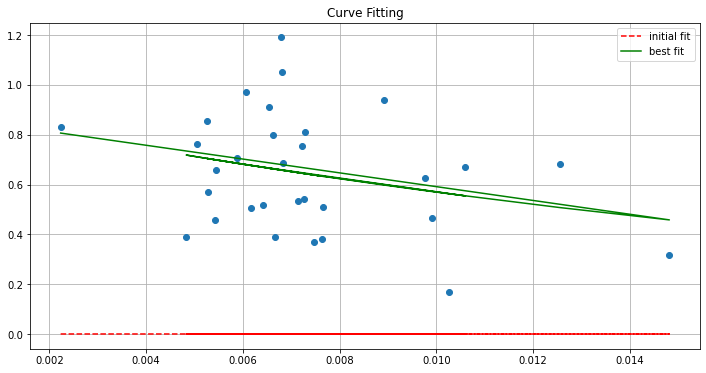

In [31]:
result = gmodel.fit(y, x=norml2[:,0], amp=5, cen=5, wid=1)

print(result.fit_report())

plt.figure(figsize=(12,6))
plt.title('Curve Fitting')
plt.plot(norml2[:,0],y, 'o')
plt.plot(norml2[:,0], result.init_fit, 'r--', label='initial fit')
plt.plot(norml2[:,0], result.best_fit, 'g-', label='best fit')
plt.legend()
plt.grid()
plt.show()